In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [ ]:
# Đặt đường dẫn đến Project
root_directory = "/content/drive/MyDrive/Colab Notebooks/pizza_classifier/"

In [5]:
data_dir="data"
dataset = torchvision.datasets.ImageFolder(root=root_directory+data_dir)

In [6]:
import json
with open('pizza_classes.json', 'w') as f:
    json.dump(dataset.classes, f)

In [ ]:

# Tạo một class PizzaClassifier để qua quá trình train
class PizzaClassifier(nn.Module):
    def __init__(self):
        super(PizzaClassifier, self).__init__()
        # Lớp tích chập đầu tiên
        # Đầu vào là ảnh có kích thước 224x224x3 (3 ở đây là channel mày RGB)
        # Đầu ra là ma trận có kích thước 224x224x32
        self.convolutional_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Lớp gộp đầu tiên
        # Đầu vào là ma trận có kích thước 224x224x32 (từ lớp chập đầu tiên)
        # Đầu ra là ma trận có kích thước 112x112x32
        self.pooling_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp tích chập thứ hai
        # Đầu vào là ma trận có kích thước 112x112x32 (từ gộp đầu tiên)
        # Đầu ra là ma trận có kích thước 112x112x64
        self.convolutional_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Lớp gộp thứ hai
        # Đầu vào là ma trận có kích thước 112x112x64 (từ chập thứ 2)
        # Đầu ra là ma trận có kích thước 56x56x64
        self.pooling_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp tích nhập thứ 3
        # Đầu vào là ma trận có kích thước 56x56x64 (từ gộp thứ 2)
        # Đầu ra là ma trận có kích thước 56x56x128
        self.convolutional_3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Lớp gộp thứ 3
        # Đầu vào là ma trận có kích thước 56x56x128 (từ chập thứ 3)
        # Đầu ra là ma trận có kích thước 28x28x128
        self.pooling_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp fully connected (linear)
        # Kích thước đầu vào: 128 * (224/8) * (224/8) = 128 * 28 * 28
        self.fully_connected_1 = nn.Linear(128 * 28 * 28, 512)
        self.fully_connected_2 = nn.Linear(512, 2)  # 2 lớp đầu ra: pizza và không phải pizza

        # Dropout để giảm overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Truyền dữ liệu qua các lớp tích chập
        x = self.pooling_1(F.relu(self.convolutional_1(x)))
        x = self.pooling_2(F.relu(self.convolutional_2(x)))
        x = self.pooling_3(F.relu(self.convolutional_3(x)))

        # Làm phẳng, chuyển ma trận 28x28x128 thành mảng 1 chiều
        x = x.view(-1, 128 * 28 * 28)

        # Đi qua các lớp fully connected
        x = F.relu(self.fully_connected_1(x))
        x = self.dropout(x)
        x = self.fully_connected_2(x)

        return x

In [8]:
def load_model(model_path, classes_path):
    # Tải thông tin classes
    with open(classes_path, 'r') as f:
        classes = json.load(f)

    # Khởi tạo mô hình
    model = PizzaClassifier().to(device)

    # Tải state_dict
    model.load_state_dict(torch.load(model_path))

    # Đặt mô hình ở chế độ evaluation
    model.eval()

    return model, classes

In [9]:
# Tải mô hình đã lưu
loaded_model, classes = load_model(root_directory+'pizza_classifier.pth', root_directory+'pizza_classes.json')
print(f"Đã tải mô hình với các lớp: {classes}")

Đã tải mô hình với các lớp: ['not_pizza', 'pizza']


In [10]:

def predict_image(model, image_path, classes):
    # Tải và transform hình ảnh
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension

    # Dự đoán
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

        # Lấy xác suất bằng softmax
        probabilities = F.softmax(outputs, dim=1)

    # Hiển thị hình ảnh và kết quả
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Dự đoán: {classes[predicted.item()]}\n"
              f"Xác suất: {probabilities[0][predicted.item()].item():.2%}")
    plt.show()

    # In kết quả chi tiết
    print(f"Dự đoán: {classes[predicted.item()]}")
    for i, prob in enumerate(probabilities[0]):
        print(f"{classes[i]}: {prob.item():.2%}")

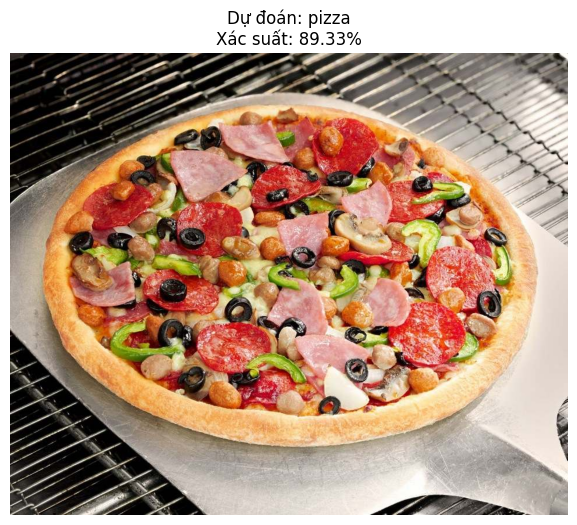

Dự đoán: pizza
not_pizza: 10.67%
pizza: 89.33%


In [17]:
predict_image(loaded_model, root_directory+"example_pizza.jpg", classes)

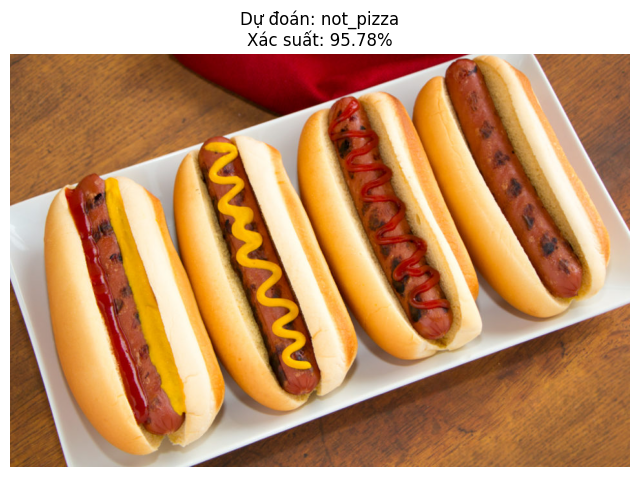

Dự đoán: not_pizza
not_pizza: 95.78%
pizza: 4.22%


In [16]:
predict_image(loaded_model, root_directory+"example_not_pizza.jpg", classes)